In [67]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

%matplotlib inline

In [53]:
#Unpickle file for modeling
df = pd.read_pickle("./modeling_df.pkl")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 19 to 39
Data columns (total 12 columns):
hotel_name          292 non-null object
rating              292 non-null float64
walk_score          292 non-null int64
res_score           292 non-null int64
attraction_score    292 non-null int64
num_reviews         292 non-null int64
num_QA              292 non-null int64
num_Tips            292 non-null float64
num_rooms           292 non-null float64
min_price           292 non-null float64
max_price           292 non-null float64
avg_price           292 non-null float64
dtypes: float64(6), int64(5), object(1)
memory usage: 29.7+ KB


In [9]:
df.head()

,hotel_name,rating,walk_score,res_score,attraction_score,num_reviews,num_QA,num_Tips,num_rooms,min_price,max_price,avg_price,walk_perfect
19,30 Bencoolen,4.5,100,12.463238,6.492837,8.855534,3.781731,8.263384,6.313775,7.024745,2.810650,3.067700,1
6,5footway.inn Project Ann Siang,3.5,100,16.751955,8.586328,7.317770,2.619422,5.911772,3.863909,4.158465,2.636037,2.750133,1
44,7 Wonders Hostel,3.5,97,11.878604,4.011113,6.349927,2.138635,4.285577,2.462549,4.111013,2.769541,2.924059,0
54,7 Wonders Hostel At Upper Dickson,4.5,100,11.156678,5.849254,1.489663,0.000000,0.000000,5.422903,3.732644,2.699775,2.820226,1
13,@ Little Red Dot,4.0,90,9.124760,3.287134,8.526637,1.577851,8.137208,3.360922,3.393095,2.387583,2.429058,0


## Diagnostic plots

In [3]:
data = df[['res_score', 'attraction_score','num_reviews','num_QA','num_Tips','num_rooms', 'walk_perfect', 'min_price','max_price','avg_price']] #'walk_score', 'res_score', 'attraction_score','num_reviews', 'num_QA', 'num_Tips', 'num_rooms', 'min_price','max_price', 'avg_price

target = df['rating'] 

X, y = data, target

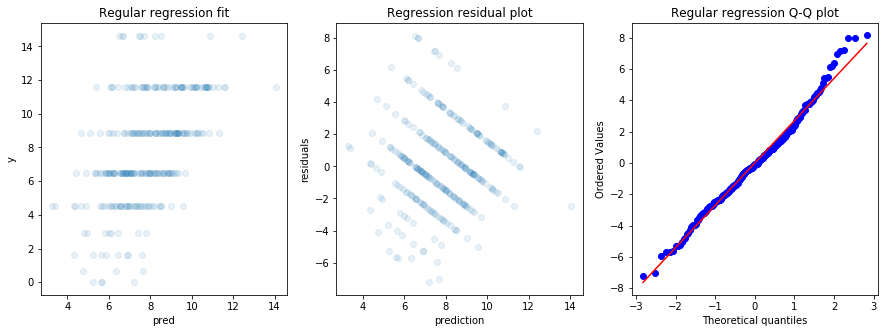

In [4]:
#redid EDA 
#plotting diagnostics again
#after boxcox transformation
data = df[['res_score', 'attraction_score','num_reviews','num_QA','num_Tips','num_rooms', 'walk_perfect', 'min_price','max_price','avg_price']] #'walk_score', 'res_score', 'attraction_score','num_reviews', 'num_QA', 'num_Tips', 'num_rooms', 'min_price','max_price', 'avg_price

target = df['rating'] 
plt.figure(figsize=(15,5))

X, y = data, target

rgr = LinearRegression()
rgr.fit(X, y)
pred = rgr.predict(X)

plt.subplot(1, 3, 1)
plt.scatter(pred, y, alpha = 0.1)
plt.title("Regular regression fit")
plt.xlabel("pred")
plt.ylabel("y")

plt.subplot(1, 3, 2)
res = (y - pred)
plt.scatter(pred, res, alpha = 0.1)
plt.title("Regression residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

plt.subplot(1, 3, 3)
pred = rgr.predict(X)
stats.probplot(res, dist="norm", plot=plt)
plt.title("Regular regression Q-Q plot");

### Baselining with OLS

In [40]:
#1st model R^2 0.278, Adj. R-squared: 0.25
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('rating ~ res_score + attraction_score + num_reviews + num_QA + num_Tips + num_rooms + walk_perfect + min_price + max_price + avg_price', data=df, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()
# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     10.83
Date:                Thu, 11 Jun 2020   Prob (F-statistic):           1.43e-15
Time:                        13:26:17   Log-Likelihood:                -703.83
No. Observations:                 292   AIC:                             1430.
Df Residuals:                     281   BIC:                             1470.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -18.8610      7.171     -2.630      0.009     -32.977      -4.745
res_score            0.1451      0.123      1.181      0.239      -0.097       0.387
attraction_score     0.2740      0.194      1.415      0.158      -0.107       0.655
num_reviews         -0.0185      0.157     -0.118      0.906      -0.328       0.291
num_QA               0.9135      0.254      3.594      0.000       0.413       1.414
num_Tips            -0.2086      0.125     -1.669      0.096      -0.455       0.037
num_rooms           -0.3881      0.119     -3.254      0.001      -0.623      -0.153
walk_perfect        -1.1790      0.606     -1.946      0.053      -2.372       0.014
min_price            1.8045      0.655      2.754      0.006       0.515       3.094
max_price           35.0240     17.526      1.998      0.047       0.525      69.523
avg_price          -27.2915     15.563     -1.754      0.081     -57.927       3.344
==============================================================================
Omnibus:                        7.783   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                7.956
Skew:                           0.323   Prob(JB):                       0.0187
Kurtosis:                       3.486   Cond. No.                     2.74e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
#2nd model - dropping highest p-values: num_reviews - adjusted R^2 improved
lm2 = smf.ols('rating ~  res_score + attraction_score + num_QA + num_Tips + num_rooms + walk_perfect + min_price + max_price + avg_price', data=df)

# Fit the model
fit2 = lm2.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     12.08
Date:                Thu, 11 Jun 2020   Prob (F-statistic):           3.99e-16
Time:                        13:26:22   Log-Likelihood:                -703.84
No. Observations:                 292   AIC:                             1428.
Df Residuals:                     282   BIC:                             1464.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -18.6652      6.963     -2.681      0.008     -32.371      -4.959
res_score            0.1455      0.123      1.187      0.236      -0.096       0.387
attraction_score     0.2720      0.193      1.413      0.159      -0.107       0.651
num_QA               0.8999      0.226      3.980      0.000       0.455       1.345
num_Tips            -0.2191      0.087     -2.509      0.013      -0.391      -0.047
num_rooms           -0.3906      0.117     -3.333      0.001      -0.621      -0.160
walk_perfect        -1.1766      0.604     -1.947      0.053      -2.366       0.013
min_price            1.7948      0.649      2.766      0.006       0.517       3.072
max_price           34.6173     17.152      2.018      0.045       0.856      68.379
avg_price          -26.9694     15.293     -1.763      0.079     -57.073       3.134
==============================================================================
Omnibus:                        8.100   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.327
Skew:                           0.331   Prob(JB):                       0.0156
Kurtosis:                       3.497   Cond. No.                     2.44e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [82]:
#experimenting with tuning
#2nd model - dropping highest p-values: num_reviews - adjusted R^2 improved
lm3 = smf.ols('rating ~  attraction_score + num_QA + num_Tips + num_rooms + walk_perfect + min_price + max_price + avg_price', data=df)

# Fit the model
fit3 = lm3.fit()

# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     13.39
Date:                Thu, 11 Jun 2020   Prob (F-statistic):           2.02e-16
Time:                        14:01:03   Log-Likelihood:                -704.57
No. Observations:                 292   AIC:                             1427.
Df Residuals:                     283   BIC:                             1460.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -17.2126      6.859     -2.509      0.013     -30.715      -3.711
attraction_score     0.4389      0.132      3.335      0.001       0.180       0.698
num_QA               0.8979      0.226      3.968      0.000       0.452       1.343
num_Tips            -0.2135      0.087     -2.447      0.015      -0.385      -0.042
num_rooms           -0.3983      0.117     -3.402      0.001      -0.629      -0.168
walk_perfect        -1.0520      0.596     -1.766      0.078      -2.225       0.121
min_price            1.7191      0.646      2.660      0.008       0.447       2.991
max_price           32.6386     17.083      1.911      0.057      -0.987      66.264
avg_price          -25.2370     15.235     -1.657      0.099     -55.224       4.750
==============================================================================
Omnibus:                        8.919   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                9.291
Skew:                           0.350   Prob(JB):                      0.00961
Kurtosis:                       3.523   Cond. No.                     1.84e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Residual plot

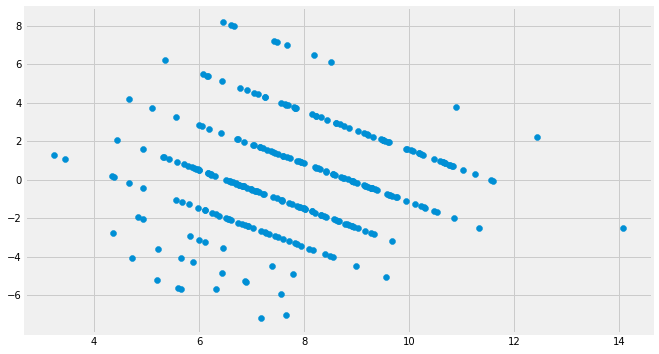

In [42]:
plt.figure(figsize=(10,6))
plt.scatter(fit2.predict(), fit2.resid);

## train/test/split

In [54]:
#first split 20%
X_train_val, X_test, y_train_val, y_test = \
train_test_split(X,y,test_size=0.2, random_state = 42)

In [55]:
#second split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [56]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

## Modeling

In [57]:
#Function for RMSE
def RMSE(actuals, preds): 
    return np.sqrt(np.mean((actuals - preds)**2))

### basic linear regression

In [58]:
lr1 = LinearRegression()
lr1.fit(X_train, y_train);

In [59]:
print("Basic Linear Regression RMSE: %.3f" %(RMSE(y_val, lr1.predict(X_val))))
print("Basic Linear Regression r^2: %.3f" %(lr1.score(X_val, y_val)))

Basic Linear Regression RMSE: 2.900
Basic Linear Regression r^2: 0.136


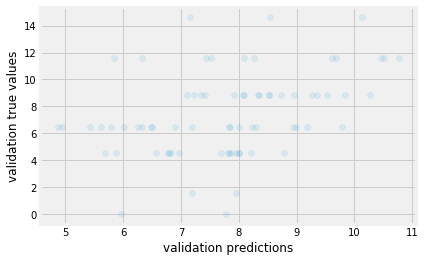

In [49]:
plt.scatter(lr1.predict(X_val), y_val, alpha=.1)
plt.plot(np.linspace(0,12,0.1),np.linspace(0,12,0.1))
plt.xlabel("validation predictions")
plt.ylabel("validation true values");

In [62]:
#cross validation
X_cv, y_cv = np.array(X), np.array(y)

cv_lm_r2s = []
cv_lm_rmse = []

for train_ind, val_ind in kf.split(X_cv, y_cv):
    
    X_cv_train, y_cv_train = X_cv[train_ind], y_cv[train_ind]
    X_val, y_val = X_cv[val_ind], y_cv[val_ind] 
    
    lr1.fit(X_cv_train, y_cv_train)
    
    cv_lm_r2s.append(lr1.score(X_val, y_val))
    cv_lm_rmse.append(RMSE(y_val, lr1.predict(X_val)))

#Check RMSE and r^2 for cross-validation.   
print('Basic Linear Regression mean cv r^2: %.3f +- %.3f' %(np.mean(cv_lm_r2s),np.std(cv_lm_r2s)))
#print('Basic Linear Regression mean cv RMSE: %.3f +- %.3f' %(np.mean(cv_lm_rmse),np.std(cv_lm_rmse)))

Basic Linear Regression mean cv r^2: 0.153 +- 0.131


In [63]:
#r^2 on test set
lr1.score(X_test, y_test)

0.37562978421255844

### LASSO regularization

In [68]:
#Define alphavec for LASSO and Ridge CV
alphavec = 10**np.linspace(-5,5,10)
#Scale the training set
std = StandardScaler()
std.fit(X_train);
#Transform the training data for LASSO regularization
X_lasso_train = std.transform(X_train)
X_lasso_val = std.transform(X_val)
#Initialize the model and perform cross-validation using in-built methods.
lr_model_2 = LassoCV(alphas = alphavec, cv=5)
lr_model_2.fit(X_lasso_train, y_train)

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.95806007737474, tolerance: 0.18104541150219486
  tol, rng, random, positive)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232.744294535665, tolerance: 0.18104541150219486
  tol, rng, random, positive)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Obj

LassoCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [69]:
#single validation set
val_set_pred_2 = lr_model_2.predict(X_lasso_val)
print('LASSO mean cv r^2: %.3f' %lr_model_2.score(X_lasso_val, y_val))
print('LASSO mean cv RMSE: %.3f' %np.sqrt(np.mean((val_set_pred_2 - y_val)**2)))

LASSO mean cv r^2: 0.196
LASSO mean cv RMSE: 3.084


In [70]:
#R^2 on test set
lr_model_2.score(std.transform(X_test), y_test)

0.2964451080609196

### Ridge Regression

In [71]:
#Scale the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [72]:
#Initialize the model and perform built-in cross-validation.
lr_model_3 = RidgeCV(alphas = alphavec, cv=5)
lr_model_3.fit(X_train_scaled,y_train)

RidgeCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [73]:
#Single validation set
val_set_pred_3 = lr_model_3.predict(X_val_scaled)

In [74]:
#R^2 and RMSE on one val set
print('Ridge mean cv r^2: %.3f' %lr_model_3.score(X_val_scaled, y_val))
print('Ridge mean cv RMSE: %.3f' %np.sqrt(np.mean((val_set_pred_3 - y_val)**2)))

Ridge mean cv r^2: 0.192
Ridge mean cv RMSE: 2.468


In [76]:
#model on test set
lr_model_3.score(std.transform(X_test), y_test)

0.3576919980249248

## Polynomials

In [77]:
#I will perform 5-fold cross-validation by using a loop, so I am going to create lists for r^2 and rmse, 
#and then calculate RMSE on the means of both lists.
cv_poly_r2s = []
cv_poly_rmse = []

for train_ind, val_ind in kf.split(X_cv,y_cv):
    
    X_train, y_train = X_cv[train_ind], y_cv[train_ind]
    X_val, y_val = X_cv[val_ind], y_cv[val_ind] 
    
    #polynomial degree 2
    poly = PolynomialFeatures(degree=2) 

    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    lm_poly = LinearRegression()
    lm_poly.fit(X_train_poly, y_train)
    
    cv_poly_r2s.append(lm_poly.score(X_val_poly, y_val))
    cv_poly_rmse.append(RMSE(y_val, lm_poly.predict(X_val_poly)))

#Check r^2 and RMSE    
print('Polynomial mean on CV r^2: %.3f +- %.3f' %(np.mean(cv_poly_r2s),np.std(cv_poly_r2s)))
print('Polynomial mean on CV RMSE: %.3f +- %.3f' %(np.mean(cv_poly_rmse),np.std(cv_poly_rmse)))

Polynomial mean on CV r^2: -0.372 +- 0.820
Polynomial mean on CV RMSE: 3.467 +- 0.681


In [78]:
#Check r^2 on the test data.
lm_poly.score(poly.transform(X_test), y_test)

-0.6210642440197554